In [1]:
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

# Задание 7.

### 1. Методом случайного поиска найти минимальное значение функции $f$ на множестве $A = \{x_1, x_2: x_1^2 + x_2^2 \leqslant 1 \}$, т.е. $y = \min\limits_{x \in A}f(x)$, где $$f(x) = x_1^3 \sin \left(\dfrac{1}{x_1} \right) + 10 x_1 x_2^4 \cos \left( \dfrac{1}{x_2} \right)$$ при $x_1 \not= 0$ и $x_2 \not= 0$, функция доопределяется по непрерывности при $x_1 = 0$ или $x_2 = 0$.

Для поиска минимума методом случайного поиска сгенерируем равномерное распределение точек по кругу и среди них найдем наименьшее значение. 

Необходимое количество точек определяется через вероятность не попасть в $\Delta x$ окрестность точки минимума. Вычислим необходимый $n$ (число точек).
Вероятность попасть в круг, но не попасть в $\Delta x$ окрестность точки минимума $x_*$, при выборе одной точки определяется как $\mathbb{P} = 1 - \frac{\pi \Delta x^2}{\pi} = 1 - \Delta x^2$, следовательно, при выборе $n$ точек $\mathbb{P}_n = (1 - \Delta x^2)^n$. Зафиксируем $p$ - вероятность не попасть в указанную окрестность. Тогда $(1 - \Delta x ^2)^n = p$, а $n = \frac{\ln p}{\ln (1 - \Delta x^2)}$.

Выберем окрестность $\Delta x$ таким образом, чтобы для фиксированной погрешности $\varepsilon$ выполнялось $|f(x_*) - f(x)| < \varepsilon$: $|f(x_*) - f(x)| < \|\nabla f \| |\Delta x|,$ оценим $\|\nabla f\|$.
$$\dfrac{\partial f}{\partial x_1} = 3 x_1^2 \sin \left( \dfrac{1}{x_1} \right) - x_1 \cos\left( \dfrac{1}{x_1} \right) + 10 x_2^$ \cos\left( \dfrac{1}{x_2} \right) \leqslant 14,$$
$$\dfrac{\partial f}{\partial x_2} = 40 x_1 x_2^3 \cos \left( \dfrac{1}{x_2} \right) + 10 x_1 x_2^2 \sin\left( \dfrac{1}{x_2} \right) \leqslant 50,$$
такми образом, $\| \nabla f \| \leqslant \sqrt{14^2 + 50^2} \approx 52 = C.$ Тогда $\Delta x = \dfrac{\varepsilon}{C}$.

Для удобства перейдем в полярную систему координат. 
При равномерном распределении точек по единичному кругу полученные случайные величины распределены следующим образом:
$$\mathbb{P}(\xi \in B) = \iint\limits_{B}p(x)dxdy = \{\text{к полярной системе координат}\} = \dfrac{1}{2\pi}\iint\limits_{B}dr^2d\varphi,$$
то есть $\varphi \sim \mathcal{U}[0,2\pi]$, а $r$ имеет функцию распределения:
$$F_r(x) = \left\{
\begin{aligned}
    &0,\quad x < 0\\
    &x^2,\quad x \in [0, 1]\\
    &1,\quad x > 1
\end{aligned}
\right.$$
С помощью метода обратных функций определяется $r \sim \sqrt{u},\ u \sim \mathcal{U}[0, 1]$.

In [2]:
def fun_min_val(x1, x2):
    res = x1 ** 3 * np.sin(1 / x1) + 10 * x1 * x2 ** 4 * np.cos(1 / x2)
    return res

In [3]:
eps = 10 ** (-2)
p = 0.05
c = 52
step = eps / c
n = int(np.log(p) / np.log(1 - step ** 2))
print(n)
 
r_sample = np.sqrt(np.random.random_sample(n))
phi_sample = 2 * np.pi * np.random.random_sample(n)

print(fun_min_val(r_sample * np.sin(phi_sample), r_sample * np.cos(phi_sample)).min())

81004599
-1.2884723054048162


### 2. Методом имитации отжига найти минимальное значение функции Розенброка $g$ в пространстве $
\mathbb{R}^2$, где $$g(x) = (x_1 - 1)^2 + 100(x_2 - x_1^2)^2.$$

Введем вспомогательные функции при решении задачи.

In [4]:
def fun_rosenbrock(x1, x2):
    return (x1 - 1) ** 2 + 100 * (x2 - x1 ** 2) ** 2

Предполагаемый следующий шаг алгоритма ($new = [new_x, new_y]$) распределен как $\mathcal{N}(cur, cur_t \sigma^2)$, где $cur = [cur_x, cur_y]$ - текущий шаг алгоритма, $cur_t$ - температура в текущий момент времени, $\sigma$ - параметр.

In [5]:
def new_state(cur_x, cur_y, t):
    new_x = normal(cur_x, np.sqrt(t) *  sigma * np.sqrt(1 + abs(cur_x)), 1)
    new_y = normal(cur_y, np.sqrt(t) * sigma * np.sqrt(1 + abs(cur_y)), 1)
    return (new_x, new_y)

Функция $$p(\Delta f, cur_t) = e^{-\frac{|\Delta f|}{cur_t}},$$ где $\Delta f = f(cur) - f(next)$, определяет вероятность, с которой на каждом шаге выбирается точка (меняется на следующую или сохраняется текущая). 

In [6]:
def p(df, t):
    return np.exp(-abs(df) / t)

В следующей функции происходит выбор точки для следующего шага алгоритма. Если $\Delta f > 0$, то всегда выбирается следующая точка (на которой достигается меньшая точка). Если неравенство не выполнено, то вероятность перехода к следующей точке определяется функцией $p(\Delta f, cur_t)$.

In [7]:
def choose_state(new_x, new_y, cur_x, cur_y, t):
    df = fun_rosenbrock(cur_x, cur_y) - fun_rosenbrock(new_x, new_y) 
    if (df > 0) or (bern(p(df, t), 1)):
        return (new_x, new_y)
    return (cur_x, cur_y)

Функция $t\_next(cur_t)$ контролирует изменение температуры (ее уменьшение с коэффициентом $k$).

In [8]:
def t_next(cur_t):
    return k * cur_t

В результате, с использованием описанных функций, на каждом шаге происходит выбор точки. Работа алгоритма останавливается, когда температура приближается к нулю ($t < 10^{-6}$).

In [9]:
from time import time


def annealing(g):

    i = 0
    t = time()

    cur_x = np.random.random_sample() * 20 - 10
    cur_y = np.random.random_sample() * 20 - 10
    cur = [cur_x, cur_y]
    if (g == 1):
        print('x_0 = ', cur_x)
        print('y_0 = ', cur_y)

    cur_t = t_0

    while cur_t > 10 ** (-6):
        i += 1
        new = new_state(cur[0], cur[1], cur_t)
        cur = choose_state(new[0], new[1], cur[0], cur[1], cur_t)
        cur_t = t_next(cur_t)
        if (g == 1):
            plt.plot(cur[0], cur[1], 'bo', alpha = 0.5)

    if (g == 1):
        plt.plot(cur[0], cur[1], '*r')
        print('x* = ', cur[0])
        print('y* = ', cur[1])
        print('f(x*, y*) = ', fun_rosenbrock(cur[0], cur[1]))
        print('Inaccuracy = ', abs(1 - cur[0]), abs(1 - cur[1]))
        print('The algorithm made ', i, ' iterations, it took ', time() - t, 'seconds.')

    return (cur[0], cur[1], i, time() - t)

In [10]:
k = 0.99
t_0 = 2
sigma = 1 / t_0

res = annealing(0)
print(res)

NameError: name 'normal' is not defined

In [ ]:
n = 100

T = np.zeros(n)

Inac_x = np.zeros(n)
Inac_y = np.zeros(n)

for j in range(0, n):
    res = annealing(0)
    T[j] = res[3]
    Inac_x[j] = abs(1 - res[0])
    Inac_y[j] = abs(1 - res[1])

print(np.median(T))
plt.hist(Inac_x, color = 'b', alpha = 0.5)
plt.show()
plt.hist(Inac_y, color = 'b', alpha = 0.5)
plt.show()

# Задание 8.

### Применить метод Монте-Карло к решению первой краевой задачи для двумерного уравнения Лапласа в единичном круге:
### $$\left\{
\begin{aligned}
&\Delta u = 0,\ (x, y) \in D\\
&u|_{\delta D} = f(x, y)\\
&u \in C^2(D),\ f \in C(\delta D)\\
&D = \{x, y:\ x^2 + y^2 \leqslant 1 \}
\end{aligned}
\right.$$
### Для функции $f(x, y) = x^2 - y^2$ найти аналитическое решение и сравнить с полученным по методу Монте-Карло.

Аналитическим решением задачи является функция $u(x, y) = x^2 - y^2.$

## Метод Монте-Карло

Разобьем область $D$ на сетку с шагом $h$. Чтобы понять, является ли точка граничной воспользумся следующими условиями:
$$\begin{gather} x^2 + y^2 \leqslant 1;\\ x^2 + y^2 + h^2 + 2h\max\{|x|, |y|\} > 1\end{gather}.$$
Если выполнено первое условие, то рассматриваемая точка с координатами $(x, y)$ принадлежит области $D$, если также выполнено и второе неравенство, то рассматриваемая точка является граничной (хотя бы одна из трех соседних точек лежит вне области $D$).

Из каждой внутренней точки можно двигаться в четырех направлениях (вправо, влево, вверх или вниз), выбор направления случаен. Последовательным переходом из одной точки в другую можно попасть на границу. Найдем сумму значений заданной на границе функции $f(x)$ при N запусках процесса из некоторой фиксированной внутренней точки $P$ и поделим полученную сумму на $N$. Таким образом, получено значение функции $u(P)$.



In [20]:
def fun_laplas(x, y):
    #print(x, y)
    return x**2 - y**2

In [21]:
def in_range(x, y): #returnes: 0 - out of range; 1 - inside; 2 - on bound
    #print('a ', x, y)
    if (x**2 + y**2 <= 1):
        if (x**2 + y**2 + h**2 + 2 * h * max(abs(x), abs(y)) > 1):
            return 2
        else:
            return 1
    else:
        return 0

In [35]:
def next_step(i, j): #gives next coordinate
    step = (np.random.binomial(1, 0.5, 1) * 2 - 1) * np.random.binomial(1, 0.5, 1)
    if (i < 19) and (i > 0):
        i += step
    elif (i <= 0):
        i += abs(step)
    else:
        i -= abs(step)
        
    if (j < 19) and (j > 0):
        j += (np.random.binomial(1, 0.5, 1) * 2 - 1) * (1 - abs(step))
    elif (j <= 0):
        j += 1 - abs(step)
    else:
        j -= 1 - abs(step)   
    return (i, j)

In [29]:
def get_value(X, Y, i0, j0):
    coord = np.array([i0, j0])
    traj_i = (i0,)
    traj_j = (j0, )
    #print(i0, j0)
    while (in_range(X[coord[0], coord[0]], Y[coord[1], coord[1]]) != 2):
        coord = next_step(coord[0], coord[1])
        #print(X[coord[0], coord[0]], Y[coord[1], coord[1]])
        #print(coord)
        traj_i = traj_i + (int(coord[0]),)
        traj_j = traj_j + (int(coord[1]),)
    return (traj_i, traj_j, fun_laplas(X[int(coord[0]), int(coord[0])], Y[int(coord[1]), int(coord[1])]))

In [30]:
def get_coord(P, X, Y):
    n_p = np.shape(P)[0]
    Coord_i, Coord_j = np.where(P == P.min())
    coord_i = Coord_i[0]
    coord_j = Coord_j[0]
    while (in_range(X[int(coord_i), int(coord_i)], Y[int(coord_j), int(coord_j)]) != 1):
        P[int(coord_i), int(coord_j)] = n_step
        Coord_i, Coord_j = np.where(P == P.min())
        coord_i = Coord_i[0]
        coord_j = Coord_j[0]
    return (int(coord_i), int(coord_j))

In [31]:
n = 20
n_step = 500

In [36]:
h = 2 / n

x = np.linspace(-1, 1, n)
y = np.linspace(-1, 1, n)
XY = np.meshgrid(x, y)
X, Y = np.meshgrid(x, y)

Passed = np.zeros((n, n))
Res_sum = np.zeros((n, n))
coord = np.zeros(2)

while np.any(Passed < n_step):
    coord = get_coord(Passed, X, Y)
    res = get_value(X, Y, coord[0], coord[1])
    #print(res)
    Passed[res[0], res[1]] += 1
    Res_sum[res[0], res[1]] += res[2]
    #print(Passed)

#print(Passed)
#print(Res_sum / Passed)



<IPython.core.display.Javascript object>


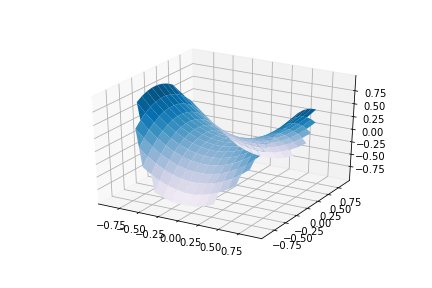

In [37]:
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
Z = X**2 - Y**2
X[X**2 + Y**2 > 1] = np.inf
Z[Z == np.inf] = 0
ax.plot_surface(X, Y, Z, cmap='PuBu')

# Задание 9.
### Рассмотреть два вида процессов:
$\bullet$ Винеровский процесс $W(t),\ t \in [0, 1],\ W(0) = 0$;

$\bullet$ Процесс Орнштейна-Уленбека $X(t),\ t \in [0, 1],\ X(0) = X_0$, то есть стационарный марковский гауссовский процесс, начальное значение $X_0$ генерируется случайным образом так, что чтобы полученный процесс был стационарным.
### Для данных гауссовских процессов:

1) найти ковариационную функцию и переходные вероятности;

2) моделировать независимые траектории процесса с данными переходными вероятностями методом добавления разбиения отрезка;

3) построить график траектории, не соединяя точки ломанной, с целью получения визуально непрерывной линии.

## Метод добавления разбиения отрезка.

Рассмотрим моделирование некоторого случайного процесса $X(t)$ на отрезке $[t_0, t_1]$

1. моделировние $X_0 = X(t_0)$;

2. моделирование $X(t_1)$ по условному распределению $[X(t_1)|X(t_0)]$;

3. рассмотрим отрезок $[t_i, t_{i + 1}]$, на концах которого определены $$X(t_i) = x_{i},\ X(t_{i + 1}) = x_{i + 1},$$ добавим узел $$t = \dfrac{t_{i + 1} - t_i}{2}$$ и построим $X(t)$ с использованием распределения случайной величины $$[X(t)|X(t_i) = x_{i},\ X(t_{i + 1}) = x_{i + 1}];$$

4. повторять третий шаг до достижения нужного шага сетки.

## Винеровский процесс
Винеровский процесс - гауссовский процесс Леви, то есть процесс с независимыми приращениями такой, что:

$\bullet\ W_0= 0;$

$\bullet\ \mu(h) = \mathbb{E}(W_{t + h} - W_{t}) = 0;$

$\bullet\ \sigma^2(h) = \mathbb{D}(W_{t + h} - W_{t}) = \sigma^2 h.$

### Найдём ковариационную функцию для винеровского процесса.

$$K(t_1, t_2) = \mathbb{E}[W(t_1)W(t_2)],$$

не ограничивая общности суждений, будем считать, что $t_1 < t_2$, тогда:

$$K(t_1, t_2) = \mathbb{E}[W(t_1)W(t_2)] = \mathbb{E}W^2(t_1) + \mathbb{E}[W(t_1) - W_0][W(t_2) - W(t_1)] = $$
$$= \sigma ^2 t_1 + \mathbb{E}W(t_1)\mathbb{E}[W(t_2) - W(t_1)] = \sigma^2 t_1.$$

Таким образом, ковариационная функция винеровского процесса:

$$K(s, t) = \min(s, t) \sigma^2.$$

### Моделирование винеровского процесса

Найдем распределение 
$$Y = [W(t_{i + \frac{1}{2}})|W(t_i) = x_i,\ W(t_{i + 1}) = x_{i + 1}],$$
где $t_{i + \frac{1}{2}} = \dfrac{t_{i + 1} - t_i}{2}$.

Одно из свойств винеровского процесса $W(t) \sim \mathcal{N}(0, \sigma^2)$, тогда $Y$ имеет плотность распределения
$$p_Y(x) = \dfrac{p_3(x_i, x_{i + \frac{1}{2}}, x_{i + 1})}{p_2(x_i, x_{i + 1})},$$

где $p_3(x_i, x_{i + \frac{1}{2}}, x_{i + 1})$ - совместная плотность $[W(t_i), W(t_{i + \frac{1}{2}}), W(t_{i + 1})]$, а $p_2(x_i, x_{i + 1})$ - совместная плотность $[W(t_i), W(t_{i + 1})]$.

Получим ковариационные матрицы $\Sigma_2$ и $\Sigma_3$, соответствующие $p_2(x),\ p_3(x)$. Вопрользуемся формулой для ковариационной функции винеровского процесса, тогда

$$
\Sigma_2 = \sigma^2 \begin{bmatrix} t_i & t_i \\ t_i & t_{i + 1}\end{bmatrix}
$$

$$
\Sigma_3 = \sigma^2 \begin{bmatrix} t_i & t_i & t_i \\ t_i & t_{i + \frac{1}{2}} & t_{i + \frac{1}{2}} \\ t_{i + \frac{1}{2}} & t_{i + \frac{1}{2}} & t_{i + 1}\end{bmatrix}
$$

Рассмотрим $n$-мерное нормальное распределение со средним $\mu$ и ковариационной матрицей $\Sigma$. Для такого распределения плотность имеет вид:

$$
p(x) = \dfrac{1}{\sqrt{(2\pi)^n|\Sigma|}} e^{-\frac{1}{2}(x - \mu)^T \Sigma^{-1}(x - \mu)}
$$

Вычислим плотность $p_Y(x)$. Заметим, что она имеет вид $C e^ {d}$, где коэффициент $C$ получен как частное коэффициентов при $p_2(x),\ p_3(x)$, а $d$ как разность степеней экспоненты в тех же плотностях.

Воспользуемся символьными вычислениями для вычисления $d$.

In [39]:
import sympy as sp

t1, t2, t3 = sp.symbols('t_1 t_2 t_3', real = True)
x1, x2, x3 = sp.symbols('x_1 x_2 x_3', real = True)

t2 = (t1 + t3) / 2

S3 = sp.Matrix([[t1, t1, t1], [t1, t2, t2], [t2, t2, t3]])
S2 = sp.Matrix([[t1, t1], [t1, t3]])
X3 = sp.Matrix([[x1], [x2], [x3]])
X2 = sp.Matrix([[x1], [x3]])

d = -sp.Rational(1, 2) * X3.T @ S3.inv() @ X3 + sp.Rational(1, 2) * X2.T @ S2.inv() @ X2
2

d[0].simplify()

(-t_1*x_3*(-x_1 + x_3) - 2*t_1*(x_2*(x_1 - x_2) + x_3*(x_2 - x_3)) + x_1*(t_1*x_3 - t_3*x_1) - x_1*(x_2*(t_1 - t_3) + (t_1 + t_3)*(-x_1 + x_3)))/(2*t_1*(t_1 - t_3))

Пусть $h = t_{i + \frac{1}{2}} - t_i$, тогда плотность распределения для процесса $Y$ имеет вид:

AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA ЧТО ТАМ С ЦИФЕРКАМИ ПОМОГИТЕ Я НЕ ХОЧУ ЭТО СЧИТАТЬ

$$
p_Y(x) = C \exp\left\{-\dfrac{2}{(t_{i + 1} - t_i)}\left(x_{i + \frac{1}{2}} - \dfrac{x_i + x_{i + 1}}{2}\right)^2\right\}, 
$$

а значит, $$ Y \sim \mathcal{N}\left( \dfrac{x_i + x_{i + 1}}{2}, \dfrac{h \sigma^2}{2}\right).$$

In [40]:
n_grid = 15
sigma = 1

In [41]:
def wiener(sigma, n_grid):
    W = np.zeros(2 ** n_grid + 1)
    W[-1] = sigma * np.random.randn()
    step = 2 ** n_grid
    first = 2 ** (n_grid - 1)
    h = 1
    for i in range(0, n_grid):
        h /= 2
        W[first :: step] = np.random.randn(2 ** i) * np.sqrt(h / 2) * sigma + (W[: -1 : step] + W[step :: step]) / 2
        first = first // 2
        step = step // 2
    return W

In [42]:
%matplotlib inline

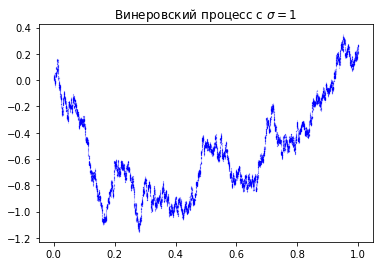

In [43]:
x = np.linspace(0, 1, 2 ** n_grid + 1)
plt.plot(x, wiener(sigma, n_grid), 'b.', ms = 0.2, alpha = 0.5)
plt.title(r'Винеровский процесс с $\sigma = 1$')
plt.show()

## Процесс Орнштейна-Уленбека

Процесс Орнштейна-Уленбека - это стационарный марковский гауссовский процесс.

### Найдем ковариационную функцию для процесса Орнштейна-Уленбека

Известно, что для корреляционной функции такого процесса верно
$$\rho(X(t_1), X(t_3)) = \rho(X(t_1), X(t_2))\rho(X(t_2), \rho(t_3)),\quad t_1 < t_2 < t_3.$$

Рассмотрим центрированный процесс Орнштейна-Уленбека, в таком случаедля любого $t$ будет верно $X(t) \sim \mathcal{N}(0, \sigma^2)$. Ковариационная функция для такого процесса будет иметь вид $$R(t_1, t_2) = \sigma^2 K(|t_2 - t_1|),$$ 

где $K(t) = \rho(X(t), X_0)$. Найдем вид $K(t).$

Рассмотрим $0 \leqslant t_1 < t_2 \leqslant 1$, тогда из свойства корреляционной функции:

$$K(t_2) = \rho(X(t_2), X(t_1))\rho(X(t_1), X(0)) = K(t_2 - t_1)K(t_1),$$

в таком случае, для любых $t \geqslant 0, s \geqslant 0$ верно $K(t + s) = K(t)K(s)$. 

Логарифм такой функции является решением уравнения Коши:
$$f(x + y) = f(x) + f(y).$$

В классе непрерывных функций уравнение Коши имеет единственное решение вида $K(t) = e^{-\lambda t},\ \lambda > 0$, следовательно

$$R(t_1, t_2) = \sigma^2 e^{-\lambda |t_1 - t_2|}, \quad \lambda > 0.$$

### Моделирование процесса Орнштейна-Уленбека


Как и винеровский процесс, процесс Орнштейна-Уленбека является гауссовским, а значит рассчитывается по аналогичной формуле, имея однако другие ковариационные матрицы.

Построим ковариационные матрицы для двух и трех случайных величин $\Sigma_2,\ \Sigma_3$ соответственно. 

Рассмотрим случайные величины $X(t_i),\ X(t_{i + \frac{1}{2}}),\ X(t_{i + 1})$,  обозначим $h = t_{i + \frac{1}{2}} - t_i$, тогда

$$
\Sigma_2 = \sigma^2 \begin{bmatrix} 1 & e^{-2\lambda h} \\ e^{-2\lambda h} & 1\end{bmatrix}
$$

$$
\Sigma_3 = \sigma^2 \begin{bmatrix} 1 & e^{-\lambda h} & e^{-2\lambda h} \\ e^{-\lambda h} & 1 & e^{-\lambda h} \\ e^{-2\lambda h} & e^{-\lambda h} & 1\end{bmatrix}
$$

Рассмотрим теперь $t_1 = 0,\ t_2 = 1$. В этом случае 

$$\Sigma_2^{(0)} = \sigma^2 \begin{bmatrix} 1 & e^{-\lambda} \\ e^{-\lambda} & 1\end{bmatrix}$$


In [48]:
t1, t2, t3 = sp.symbols('t_1 t_2 t_3', real = True)
x0, x1, x2, x3 = sp.symbols('x_0 x_1 x_2 x_3', real = True)
lam, h = sp.symbols('\lambda h', real = True)
t2 = (t1 + t3) / 2
h = t2 - t1

S3 = sp.Matrix([[1, sp.exp(-lam * h), sp.exp(-2 * lam * h)], 
             [sp.exp(-lam * h), 1, sp.exp(-lam * h)], 
             [sp.exp(-2 *lam * h), sp.exp(-lam * h), 1]])
S2 = sp.Matrix([[1, sp.exp(-2 * lam * h)], [sp.exp(-2 * lam * h), 1]])
X3 = sp.Matrix([[x1], [x2], [x3]])
X2 = sp.Matrix([[x1], [x3]])

d = -sp.Rational(1, 2) * X3.T @ S3.inv() @ X3 + sp.Rational(1, 2) * X2.T @ S2.inv() @ X2
2

S_20 = S2.subs(h, sp.Rational(1, 2))
X0 = sp.Matrix([[x0], [x1]])
d_0 = -sp.Rational(1, 2) * X0.T @ S_20.inv() @ X0
d_0 = d_0[0].simplify()


d = d[0].simplify()

In [49]:
d_0

-(x_0*(x_0*exp(\lambda) - x_1) - x_1*(x_0 - x_1*exp(\lambda)))/(4*sinh(\lambda))

In [50]:
d

(-(x_1*(x_1 - x_3*exp(\lambda*(t_1 - t_3))) - x_3*(x_1*exp(\lambda*(t_1 - t_3)) - x_3))*(exp(2*\lambda*(t_1 - t_3)) - 2*exp(\lambda*(t_1 - t_3)) + 1)*(exp(3*\lambda*(t_1 - t_3)) - 3*exp(2*\lambda*(t_1 - t_3)) + 3*exp(\lambda*(t_1 - t_3)) - 1) - (exp(2*\lambda*(t_1 - t_3)) - 1)*(-x_1*(x_1 - x_2*exp(\lambda*(t_1 - t_3)/2))*(exp(2*\lambda*(t_1 - t_3)) - 2*exp(\lambda*(t_1 - t_3)) + 1)**2 + x_2*(x_3*(exp(\lambda*(t_1 - t_3)) - 1)*(exp(3*\lambda*(t_1 - t_3)) - 3*exp(2*\lambda*(t_1 - t_3)) + 3*exp(\lambda*(t_1 - t_3)) - 1)*exp(\lambda*(t_1 - t_3)/2) + (x_1*(exp(2*\lambda*(t_1 - t_3)) - 2*exp(\lambda*(t_1 - t_3)) + 1)*exp(\lambda*(t_1 - t_3)/2) - x_2*(exp(3*\lambda*(t_1 - t_3)) - exp(2*\lambda*(t_1 - t_3)) - exp(\lambda*(t_1 - t_3)) + 1))*(exp(2*\lambda*(t_1 - t_3)) - 2*exp(\lambda*(t_1 - t_3)) + 1)) + x_3*(x_2*(exp(2*\lambda*(t_1 - t_3)) - 2*exp(\lambda*(t_1 - t_3)) + 1)**2*exp(\lambda*(t_1 - t_3)/2) - x_3*(exp(\lambda*(t_1 - t_3)) - 1)*(exp(3*\lambda*(t_1 - t_3)) - 3*exp(2*\lambda*(t_1 - t_

Подставляя полученные матрицы в соответствующие формулы (см. винеровский процесс) получим, что 

$$[X(1)|X(0)] \sim \mathcal{N} (x_0e^{-\lambda}, \sigma^2(1 - e^{-2\lambda}))$$

$$[X(t_{i + \frac{1}{2}})|\ X(t_i) = x_i,\ X(t_{i + 1}) = x_{i + 1}] \sim \mathcal{N}\left(\dfrac{x_i + x_{i + 1}}{e^{\lambda h} + e^{-\lambda h}}, \dfrac{\sigma^2 (e^{2\lambda h} - 1)}{e^{2\lambda h} + 1} \right).$$

In [51]:
n_grid = 14
sigma = 1
lam = 5

In [52]:
def ou_mean(x1, x2, h, lam):
    return((x1 + x2) / (np.exp(lam * h) + np.exp(-lam * h)))

In [53]:
def ou_scale(h, sigma, lam):
    return((sigma ** 2) * (np.exp(2 * lam * h) - 1)/(np.exp(2 * lam * h) + 1))

In [60]:
def ornstein_uhlenbeck(sigma, lam, n_grid):
    OU = np.zeros(2 ** n_grid + 1)
    OU[0] = np.random.rand() * sigma
    OU[-1] =  sigma * np.sqrt(1 - np.exp(-2 * lam)) * np.random.randn() + OU[0] * np.exp(-lam)
    step = 2 ** n_grid
    first = 2 ** (n_grid - 1)
    h = 1
    for i in range(0, n_grid):
        h /= 2
        OU[first :: step] = np.random.randn(2 ** i) * np.sqrt(ou_scale(h, sigma, lam)) + ou_mean(OU[: -1 : step], OU[step :: step], h, lam)
        first = first // 2
        step = step // 2
    return OU

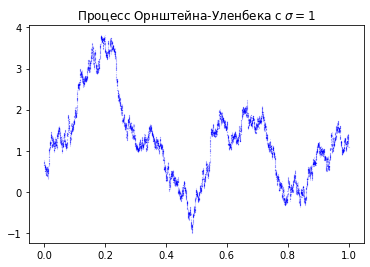

In [61]:
x = np.linspace(0, 1, 2 ** n_grid + 1)
plt.plot(x, ornstein_uhlenbeck(sigma, lam, n_grid), 'b.', ms = 0.2, alpha = 0.5)
plt.title(r'Процесс Орнштейна-Уленбека с $\sigma = 1$')
plt.show()

# Задание 10.

## Произвести фильтрацию одномерного процесса Орнштейна-Уленбека.

### 1. Используя генератор белого шума, добавить случайную ошибку с известной дисперсией к реализации процесса Орнштейна-Уленбека.

Рассмотрим процесс Орнштейна-Уленбека $x_n = X(t_n)$ с заданными параметрами $\lambda > 0,\ \sigma$ на сетке $\{t_n = nh\ |\ n = 1,\ldots,N;\ h = \frac{1}{N}\}$. 

Пусть $x_1 = X(t_1) \sim \mathcal{N}(0, \sigma^2)$, тогда процесс $x_n$ может быть записан в виде:
$$x_n = a x_{n - 1} + \nu_n,$$

где $\nu_n \sim \mathcal{N}(0, q)$.

Введем зашумленный сигнал $y_n$ вида
$$y_n = x_n + \varepsilon_n,$$
где $\varepsilon_n$ - ошибка с заданным характером распределения (в данной задаче нормальным или распределением Коши) с нулевым сдвигом и масштабом $r$ (он также считается известным).

Найдем параметры системы $a$ и $q$. Для этоого запишем ковариациооную функцию процесса в моменты $t_n$ и $t_{n + 1}$:

$$ R(t_n, t_n) = \mathbb{D}x_n = \sigma^2, $$
$$ R(t_n, t_{n + 1}) = a \mathbb{D}x_n = a \sigma^2, $$
$$ R(t_{n + 1}, t_{n + 1}) = \mathbb{D}(x_{n + 1}) = a^2\mathbb{D}x_n = a^2\sigma^2 + q =  \sigma^2.$$

Из полученной системы находим искомые параметры:
$$a = e^{\lambda h}, \quad q = \sigma^2(1 - e^{-2\lambda}).$$

### 2. При помощи одномерного фильтра Калмана оценить траекторию процесса по зашумленному сигналу, параметры процесса и белого шума считать известными.

Рассмотрим работу фильтра Калмана на $n$-ом шаге.

Введем обозначения: 

$\hat x_{n|n}$  - оценка значения $x_n$ при известных $y_1, \ldots, y_n$;

$\hat x_{n|(n - 1)}$ - предполагаемое значение $x_n$ на основе предыдущего шага в соответствии с динамической системой;

$p_{n|n}$ - дисперсия ошибки фильтрации;

$p_{n|(n - 1)}$ - прогнозируемая диспресия на основе предыдущего шага.

Фильтр Калмана работает по следующему алгоритму:

1) исходя из динамической системы получаем:
$$ \hat x_{n|(n - 1)} = a \hat x_{(n - 1)|(n - 1)},\quad p_{n|(n - 1)} = a^2 p_{(n - 1)|(n - 1)} + q;$$
2) вычисляем разницу между наблюдаемым процессом и прогнозом $\delta_n$ и коэффициент усиления Калмана $k_n$:
$$\delta_n = y_n - \hat x_{n|(n - 1)},\quad k_n = \dfrac{p_{n|(n - 1)}}{p_{n|(n - 1)} + r};$$
3) рассчитываем новое значение $x_{n|n}$ как линейную комбинацию предсказанного и наблюдаемого значений:
$$\hat x_{n|n} = \hat x_{n|(n - 1)} + k_n \delta_n,\quad p_{n|n} = (1 - k_n)p_{n|(n - 1)}.$$

In [62]:
def kalman(y, a, q, r):
    n = len(y)
    p = np.zeros(n)
    x_res = np.zeros(n)
    x_res[0] = y[0]
    p[0] = r
    for i in range(1, n):
        x_pred = a * x_res[i - 1]
        p_pred = a**2 * p[i - 1] + q
        delta = y[i] - x_pred
        k = p_pred / (p_pred + r)
        x_res[i] = x_pred + k * delta
        p[i] = (1 - k) * p_pred
    return [x_res, p]

### Нормальная ошибка

In [63]:
lam = 0.01
sigma = 1

r = 0.01

n_grid = 14

In [67]:
n = int(2 ** n_grid + 1)

h = 1 / (n - 1)

a = np.exp(-lam * h)
q = (sigma ** 2) * (1 - np.exp(-2 * lam * h))

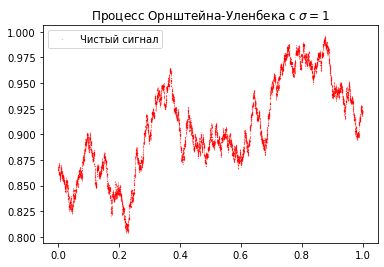

In [68]:
# получение процесса Орнштейна-Уленбека

x = ornstein_uhlenbeck(sigma, lam, n_grid)

pl = np.linspace(0, 1, 2 ** n_grid + 1)
plt.plot(pl, x, 'r.', ms = 0.2, label = 'Чистый сигнал')
plt.title(r'Процесс Орнштейна-Уленбека с $\sigma = 1$')
plt.legend()
plt.show()

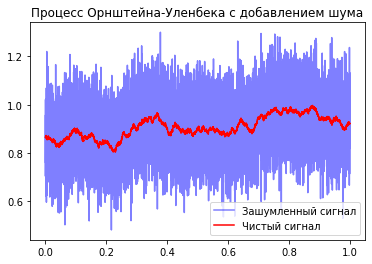

In [69]:
#добавление нормального шума

noise = np.sqrt(r) * np.random.randn(n)
y = x + noise


plt.plot(pl, y, 'b', ms = 0.2, alpha = 0.5, label = 'Зашумленный сигнал')
plt.plot(pl, x, 'r', ms = 0.2, label = 'Чистый сигнал')
plt.title(r'Процесс Орнштейна-Уленбека с добавлением шума')
plt.legend()
plt.show()

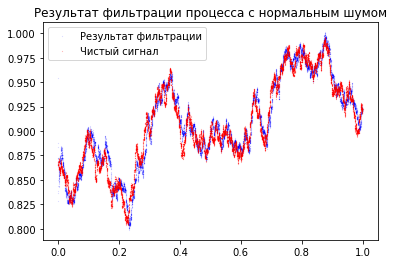

In [70]:
#фильтрация
z = kalman(y, a, q, r)[0]
plt.plot(pl, z, 'b.', ms = 0.2, alpha = 0.5, label = 'Результат фильтрации')
plt.plot(pl, x, 'r.', ms = 0.2, label = 'Чистый сигнал')
plt.title(r'Результат фильтрации процесса с нормальным шумом')
plt.legend()
plt.show()

### Ошибка с распределением Коши

In [71]:
lam = 0.01
sigma = 1

r = 0.0001

n_grid = 14

In [73]:
n = int(2 ** n_grid + 1)

h = 1 / (n - 1)

a = np.exp(-lam * h)
q = (sigma ** 2) * (1 - np.exp(-2 * lam * h))

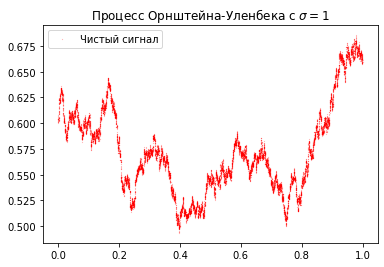

In [74]:
# получение процесса Орнштейна-Уленбека

x = ornstein_uhlenbeck(sigma, lam, n_grid)

pl = np.linspace(0, 1, 2 ** n_grid + 1)
plt.plot(pl, x, 'r.', ms = 0.2, label = 'Чистый сигнал')
plt.title(r'Процесс Орнштейна-Уленбека с $\sigma = 1$')
plt.legend()
plt.show()

In [78]:
#датчик распределения Коши
def cauchy(x_0, gamma, size):
    sample = np.random.random_sample(size)
    return gamma * (np.tan(np.pi * (sample - 0.5))) + x_0

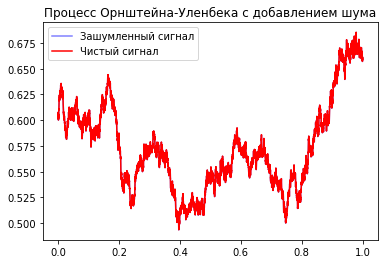

In [79]:
#добавление шума c распределением Коши

noise = cauchy(0, r, 1)
y = x + noise


plt.plot(pl, y, 'b', ms = 0.2, alpha = 0.5, label = 'Зашумленный сигнал')
plt.plot(pl, x, 'r', ms = 0.2, label = 'Чистый сигнал')
plt.title(r'Процесс Орнштейна-Уленбека с добавлением шума')
plt.legend()
plt.show()

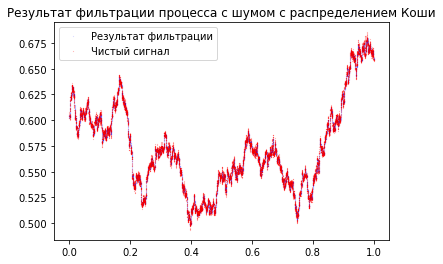

In [80]:
#фильтрация
z = kalman(y, a, q, r)[0]
plt.plot(pl, z, 'b.', ms = 0.2, alpha = 0.5, label = 'Результат фильтрации')
plt.plot(pl, x, 'r.', ms = 0.2, label = 'Чистый сигнал')
plt.title(r'Результат фильтрации процесса с шумом с распределением Коши')
plt.legend()
plt.show()

# Задание 11.
### Построить двумерное пуассоновское поле, отвечающее пуассоновскому процессу:

### 1. Первая интерпритация: система массового обслуживания. При этом, первая координата поля - время поступления заявки в СМО (равномерное распределение), вторая - время ее обслуживания (распределение $\chi^2$ с 10 степенями свободы).

Рассмотрим работу системы массового обслуживания на отрезке времени $[0, T]$. За это время на участок приходит $\eta \sim \mathcal{Pois}(\lambda T)$, где $\lambda$ - интенсивность очереди. Момент прихода $i-$го человека $t_i \sim \mathcal{U}([0, T])$, а его время ожидания $s_i \sim \mathcal{\chi^2}(10)$. Обозначим время обработки заявки $i$-го человека через $X_i$, тогда:

$$
X_i = 
\left\{
\begin{aligned}
& t_i + s_i,\ X_{i - 1} \leqslant t_i\ (\text{в очереди никого нет});\\
& X_{i - 1} + s_i,\ X_{i - 1} > t_i\ (\text{очередь не пуста}).
\end{aligned}
\right.
$$

В таком случае, число людей в очереди в момент времени $t$ равен $N(t) = \sum\limits_{i = 0}^{\eta}\mathbb{I}_{t \in [t_i, X_i)}$, то есть сумма людей, которые уже встали в очередь и запросы которых не были обработаны к моменты $t$.

Заметим, что очередь не будет накапливаться до бесконечности лишь в том случае, если среднее время обработки заявки больше, чем средний интервал между появлением новых людей в очереди. 

$t_i \sim \mathcal{U}[0, T]$, следовательно $(t_{i + 1} - t_i) \sim \mathcal{Exp}(\lambda)$. Известно, что $$\mathbb{E}(t_{i + 1} - t_i) = \dfrac{1}{\lambda},\quad \mathbb{E}s_i = 10.$$

Тогда наше условие корректной работы СМО (отсутствие бесконечно длинной очереди) эквивалентно $\dfrac{1}{\lambda} < 10$.

In [81]:
def chi2_rnd(k, size):
    mu = 0
    sigma = 1
    return np.sum((np.reshape(np.random.rand(size * k) ** 2, (size, k))), 1)

In [82]:
# определение значения параметра
lam = 0.1
T = 100
k = 10
n = 1000

In [83]:
def queue_mod(t):
    eta = np.size(t)
    s = chi2_rnd(k, eta)
    X = np.zeros(eta)
    X[0] = t[0] + s[0]
    for i in range(1, eta):
        X[i] = max(X[i - 1], t[i]) + s[i]
    N = lambda tau: ((tau > t) * (tau < X)).sum()
    return [N, X]

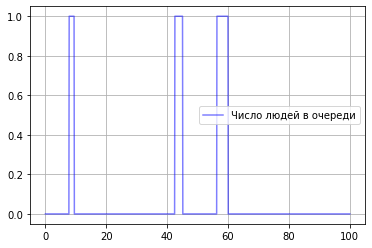

In [84]:

eta = np.random.poisson(lam * T)

t = np.sort(T * np.random.rand(int(eta)))

[N, X] = queue_mod(t)

tt = np.linspace(0, T, n)
y = np.zeros(n)
for i in range(0, n):
    y[i] = N(tt[i])

plt.plot(tt, y, color = 'b', alpha = 0.5, label = 'Число людей в очереди')
plt.grid()
plt.legend()
plt.show()

### 2. Вторая интерпретация: система массового обслуживания с циклической интенсивностью $\lambda(1 + \cos(t))$ и единичными скачками. Свести данную задачу моделирования неоднородного пуассоновского процесса при помощи метода Льюса и Шедлера к моделированию двумерного пуассоновского поля, где первая координата имеет равномерное распределение, а вторая - распределение Бернулли.

Рассмотрим работу СМО c циклической интенсивностью $\lambda(t)$ на отрезке времени $[0, T]$. $\lambda(t) = \lambda (1 - \cos(t)) \leqslant 2\lambda$ для любого $t \in [0, T]$. Тогда получим число людей, встающих в очередь $\eta \sim \mathcal{Pois}(2\lambda)$ и получим соответствующее число равномерно распределенных моментов времени, в которые приходят эти люди $t_1', \ldots, t_{\eta}'$. 

Получим новую выборку моментов времени $t_1, \ldots, t_n$ следующим образом: каждую случайную величину $t_i'$ будем принимать в новую выборку с вероятностью $p_i = \dfrac{\lambda(t_i')}{2 \lambda} = \dfrac{1 + \cos(t_i')}{2}.$ Полученная выборка будет определнять моменты появления новых людей в очереди в системе массового обслуживания с циклической интенсивностью. 

Далее рассуждения повторяют пункт 1 задания 11.

In [85]:
lam = 0.1
T = 100
k = 10
n = 1000

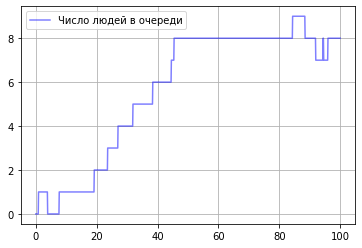

In [86]:
eta = np.random.poisson(2 * lam * T)
t1 = (T * np.random.rand(int(eta)))
idx = (np.random.rand(eta)) < ((1 + np.cos(t1)) / 2)
t = t1[idx]

[N, X] = queue_mod(t)

tt = np.linspace(0, T, n)
y = np.zeros(n)
for i in range(0, n):
    y[i] = N(tt[i])

plt.plot(tt, y, color = 'b', alpha = 0.5, label = 'Число людей в очереди')
plt.legend()
plt.grid()
plt.show()

### 3. Третья интерпретация: работа страховой компании. Первая координата - момент наступления страхового случая (равномерное распределение), вторая координата - величина ущерба (распределение Парето). Поступление капитала по времени линейно со скоростью $c > 0$, начальный капитал $W > 0$.

Рассмотрим работу страховой компании на отрезке времени $[0, T]$. Число страховых случаев $N \sim \mathcal{Pois}(\lambda)$. Моменты наступления страховых случаев $t_i \sim \mathcal{U}(0, T)$, величины ущерба в соответствующие моменты времени $X_i \sim \mathcal{Par}(k)$, где $\mathcal{Par}(k)$ - распределение Парето с параметром $k$.

Будем моделировать распределение Парето методом обращения функции распределения. Для распределения Парето:
$$F_{Par} = 1 - \left[ \frac{1}{x}\right]^k.$$
Тогда при $y \sim \mathcal{U}[0, 1]$ случайная величина $x = (1 - y)^-\frac{1}{k}\ \sim \mathcal{Par}(k).$

In [87]:
def Pareto(k, size):
    y = np.random.rand(size)
    return (1 - y) ** (- (1 / k))

Капитал поступает линейно со скоростью $c$, а начальный капитал равен $W$. Также при возникновении страховых случаев необходимо выплачивать соответствующие величины ущерба, следовательно:
$$K(t) = W + ct - \sum\limits_{i = 1}^{N(t)} X_i,$$
где $N(t)$ - число страховых случаев к моменту времени $t$.

Рассмотрим поведение системы при различных параметрах. Будем рассматривать $k > 1$, так как в противном случае математическое ожидание случайной величины не определено. 

Рассмотрим среднее значение капитала в момент времени $t$:
$$\mathbb{E}K(t) = W + ct - \lambda t \frac{k}{k - 1} = W + t(c - \dfrac{\lambda k}{k + 1}).$$
Таким образом, при $c > \dfrac{\lambda k}{k - 1}$ капитал будет расти, а в обратном случае быстро будет израсходован.

In [88]:
lam = 1
k = 2
T = 100
c = 2
W = 50
n = 1000

In [89]:
def K(tau, f, xx, t):
    if (tau < t[0]):
        return W + c*tau
    res = [((t[i] <= tau) & (t[i + 1] > tau)) for i in range(0, eta - 1)]
    if (np.sum(res) == 0):
        res = np.concatenate((res, [1])).astype(bool)
    else:
        res = np.concatenate((res, [0])).astype(bool)
    if (W + c * tau - xx[res] <= 0):
        f = False
    return f * (W + c * tau - xx[res]) 


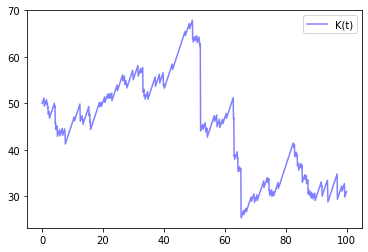

In [90]:
eta = np.random.poisson(lam * T)
t = np.sort(T * np.random.rand(eta))
X = Pareto(k, eta)
f = True

kk = np.zeros(eta)
xx = np.zeros(eta)
kk[0] = W
for i in range(1, eta):
    xx[i] = xx[i - 1] + X[i]
    
tt = np.linspace(0, T, n)
yy = np.zeros(n)

for i in range(0, n):
    yy[i] = K(tt[i], f, xx, t)

    
plt.plot(tt, yy, color = 'b', alpha = 0.5, label = 'K(t)')
plt.legend()
plt.show()